In [27]:
import IPython.display
IPython.display.Audio("Bass1.wav")

In [28]:
import wave
import numpy as np

def get_wave_profile(file):
    wf = wave.open(file, "rb")
    # モノラルかステレオか
    nc = wf.getnchannels() 
    # サンプルの大きさ(量子化ビット数)
    ss = wf.getsampwidth()
    # サンプリングレート
    sr = wf.getframerate()
    # フレーム数
    fl = wf.getnframes()
    # 生データ(バイナリ)
    data = wf.readframes(fl)
    # NumPy配列に変換
    data = np.frombuffer(data, dtype="int%d" % (8 * ss))
    # 正規化
    data = data / data.max()
    print(file)
    print("\tチャネル数\t\t%s" % nc)
    print("\t量子化バイト数\t\t%s Byte" % ss)
    print("\tサンプリングレート\t%s Hz" % sr)
    print("\tフレーム数\t\t%s" % fl)
    print("\t秒数\t\t\t%.3f 秒" % (fl / sr))
    wf.close()
    params = {
        "channels": nc,
        "width": ss,
        "rate": sr,
        "length": fl
    }
    return data, params
  
data, params = get_wave_profile("Bass1.wav")


Bass1.wav
	チャネル数		1
	量子化バイト数		2 Byte
	サンプリングレート	44100 Hz
	フレーム数		176400
	秒数			4.000 秒


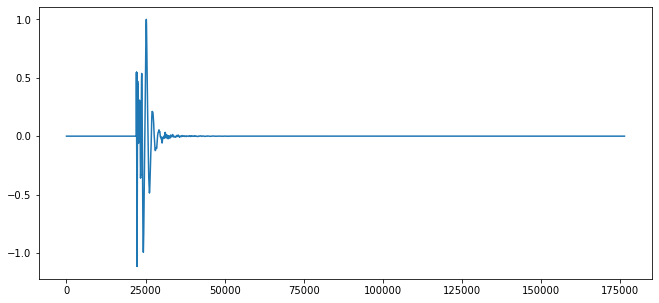

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 5))
plt.plot(range(len(data)), data / data.max())
plt.show()

In [30]:
import matplotlib.pyplot as plt 
import librosa
import librosa.display

In [31]:
audio_path = 'Bass1.wav' 
y, sr = librosa.load(audio_path) 

In [32]:
D = np.abs(librosa.stft(y))
log_D = librosa.amplitude_to_db(D, ref=np.max)

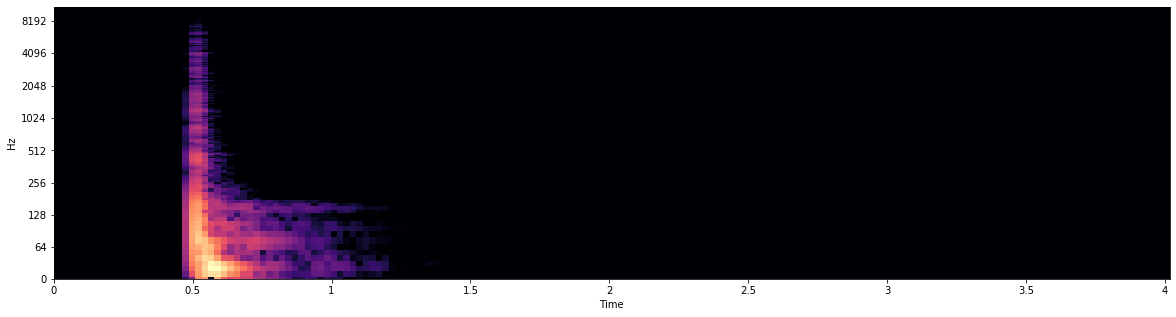

In [33]:
plt.figure(figsize=(20,5))
librosa.display.specshow(log_D, x_axis='time', y_axis='log')

In [34]:
def fft(X, params):
    
    X = np.fft.fft(X)
  
    freqs = np.fft.fftfreq(len(X), d=1 / params["rate"])
    gain = np.abs(X)
 
    phase = np.angle(X)
    return freqs, gain, phase

Bass1.wav
	チャネル数		1
	量子化バイト数		2 Byte
	サンプリングレート	44100 Hz
	フレーム数		176400
	秒数			4.000 秒


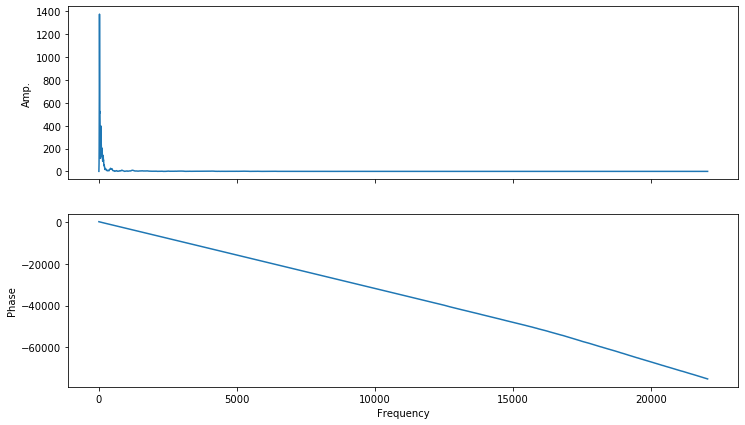

In [35]:
data = get_wave_profile("Bass1.wav")
f, g, p = fft(*data)
n = len(f)

f, g, p = f[:n//2], g[:n//2], p[:n//2]
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axs[0].plot(f, g)

axs[1].plot(f, np.unwrap(p))
axs[0].set_ylabel("Amp.")
axs[1].set_ylabel("Phase")
axs[1].set_xlabel("Frequency")
plt.show()

In [36]:
# res: フレーム長
# intv : フレーム周期
def stft_hamming(X, params, res=512, intv=32):
    f = None
    gs = [] # (フレーム数, フレーム長)の行列
    for i in range(len(X) // intv):
        w = X[i * intv:i * intv + res]
        if len(w) != res:
            continue
        # ハミング関数．
        hamm = np.hamming(len(w))
        f, g, _ = fft(w * hamm, params)
        gs.append(g[:res//2])
    return f[:res//2], np.array(gs)

In [41]:
data = get_wave_profile("Bass1.wav")
f, gs = fft(*data)

# 音声に対してSTFTを行う場合はこっち
# v_data = get_wave_profile("voice.wav")
# f, gs = stft_hamming(*v_data)

plt.figure(figsize=(7, 3))
plt.plot(f, 20 * np.log10(gs[10] / gs.max()))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")
plt.show()

Bass1.wav
	チャネル数		1
	量子化バイト数		2 Byte
	サンプリングレート	44100 Hz
	フレーム数		176400
	秒数			4.000 秒


ValueError: too many values to unpack (expected 2)

In [38]:
def mel_filter(f, spec, f_min, f_max, n=20):
    mel = lambda x: 1000 * (np.log10(x / 1000 + 1))/ np.log10(2)
    invmel = lambda y:1000 * (np.power(10, (y * np.log10(2)/ 1000)) - 1)
    (m_min, m_max) = mel(f_min), mel(f_max)
    mp = invmel(np.linspace(m_min, m_max, n + 2))
    t = np.arange(f_min, f_max)
    mspec = np.zeros((spec.shape[0], n))
    for i in range(1, n + 1):
        mf1 = lambda x: 1 / (mp[i] - mp[i - 1]) * (x - mp[i - 1])
        mf2 = lambda x: 1 / (mp[i + 1] - mp[i]) * (mp[i + 1] - x)
        mf = lambda x: np.maximum(np.minimum(mf1(x), mf2(x)), 1e-80)
        # i番目のフィルタが周波数に対して作用する度合い
        coef = mf(f)
        # @ はドット積(spec.dot(coef))と同義
        mspec[:, i - 1] = np.log10(spec @ coef)
    return mp, mspec

In [42]:
data = get_wave_profile("Bass1.wav")
f, gs = fft(*data)
mp, ms = mel_filter(f, gs, 0, 25000, 20) # 20 or 80

plt.figure(figsize=(7, 3))
plt.plot(f, np.log10(gs[180]))
plt.plot(mp[1:-1], ms[180], marker='o')
plt.show()

Bass1.wav
	チャネル数		1
	量子化バイト数		2 Byte
	サンプリングレート	44100 Hz
	フレーム数		176400
	秒数			4.000 秒


ValueError: too many values to unpack (expected 2)

Bass1.wav
	チャネル数		1
	量子化バイト数		2 Byte
	サンプリングレート	44100 Hz
	フレーム数		176400
	秒数			4.000 秒


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


[-inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


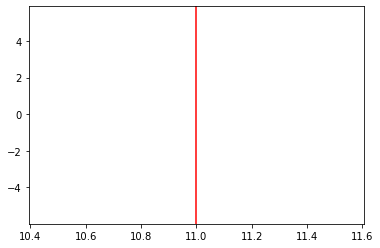

In [40]:
from scipy.fftpack.realtransforms import dct
def get_cepstrum(mp, mspec):
    ceps = dct(ms, type=2, norm="ortho", axis=1)
    return ceps

v_data = get_wave_profile("Bass1.wav")
f, gs = stft_hamming(*v_data, res=1024, intv=64)
mel_data = mel_filter(f, gs, 0, 25000, 80)
ceps = get_cepstrum(*mel_data)
cep = ceps[180]
plt.plot(range(len(cep)), cep)
plt.ylim((y.min() - 5, y.max() + 5))
# 低い方から12個までを特徴量
thres = 12
plt.vlines(thres - 1, -100, 100, color="r")
print(cep[:thres])